In [1]:
import music21 as m21
import pandas as pd
import abc_utils as abc
from matplotlib import pyplot as plt
import numpy as np

RANDOM_STATE = 42

In [2]:
#  load in the dataset
train, test = abc.load_harmonization_train_test()

In [3]:
print(train.__len__(), test.__len__())

41565 419


In [4]:
found_S = train['output'].str.find('S')
without_S = train['output'][found_S == -1]

bad_cleaning = without_S[without_S.str.find('_') == -1]

In [5]:
def get_visualization_counts(output: pd.Series) -> pd.DataFrame:
    """
    Takes in the output column of a DataFrame and outputs a new DataFrame containing relevant information about the 
    songs in the output for use in visualization

    Parameters:
        output (pd.Series): the "output" column of the huge dataset

    Returns:
        vis_df (pd.DataFrame): the relevant visualization information
    """
    # initialzie output dataframe
    vis_df = pd.DataFrame()

    # helper to get the chords 
    def get_chord(text: str):
        chords = abc.abc_to_dataframe(text)['chord'].values.astype(list)
        return chords
        

    # helper to get the melody 
    def get_melody_notes(text: str):
        melody = abc.abc_to_dataframe(text)['melody'].values.astype(list)
        return melody
    
    # helper to get the kseys
    def get_key(text: str):
        # get the score
        abc_score = m21.converter.parse(text, format='abc')
        
        # get the part
        part = abc_score.parts[0]

        # flatten the part and iterate through to find the key(s)
        key = None
        for item in part.flatten():
            # TODO: Ask: Are we sure there could be multiple keys? It slows things down a ton to look at the whole song when... hmm.
            if isinstance(item, m21.key.Key):
                key = item.__str__()
                break
                # TODO: Implement ordering of the keys to obtain frquencies of each key
        return key
    
    def get_length(melody: list):
        return len(melody)

    # use the functions to create the new dataframe
    vis_df['chords'] = output.apply(get_chord)
    vis_df['keys'] = output.apply(get_key)
    vis_df['melody'] = output.apply(get_melody_notes)
    vis_df['length'] = vis_df['melody'].apply(get_length)

    return vis_df

# use the function to get the dataframe of chords and notes
# Histogram of the roman numeral chords for all of the songs in the data set
# "confusion mmatrix" prob of transitioning from I to V


In [6]:
# test it
vis_df = get_visualization_counts(bad_cleaning.iloc[:50])
vis_df.head(5)


,chords,keys,melody,length
518249,"[0, 0, 1, 1, 1, 1, 1, 8, 8, 8, 8, 8, 8, 8, 8, ...",C major,"[65, 66, 68, 77, 77, 75, 73, 73, 72, 63, 65, 6...",112
518251,"[0, 1, 1, 1, 1, 6, 6, 1, 1, 1, 1, 1, 8, 1, 1, ...",G major,"[70, 75, 74, 72, 70, 72, 70, 67, 70, 75, 75, 7...",61
518253,"[0, 0, 1, 1, 1, 1, 1, 1, 8, 8, 8, 8, 8, 8, 1, ...",C major,"[65, 68, 73, 68, 77, 73, 77, 80, 68, 68, 68, 6...",156
518260,"[0, 0, 0, 1, 1, 1, 1, 1, 1, 15, 15, 15, 15, 15...",C major,"[68, 68, 77, 77, 77, 68, 68, 68, 77, 75, 75, 7...",162
518261,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 8, 8, ...",C major,"[68, 68, 68, 70, 68, 68, 73, 77, 68, 77, 68, 7...",81


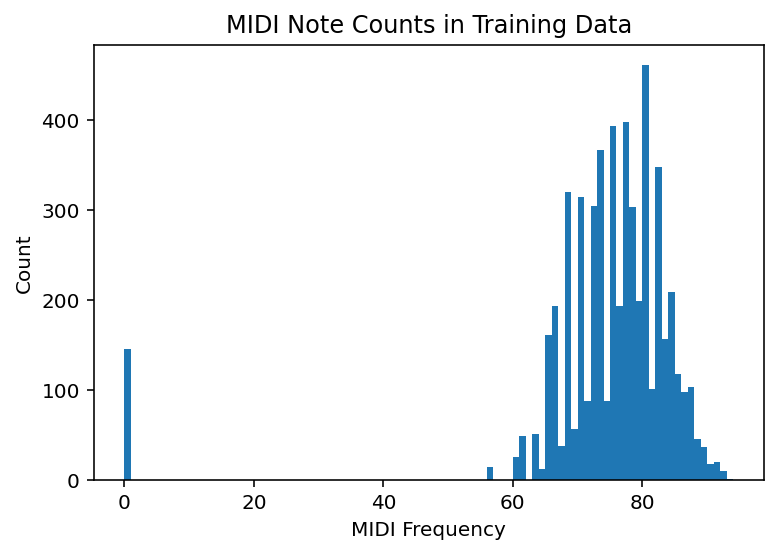

Number of Rests: 0
Lowest Note MIDI Value: 0
Highest Note MIDI Value: 94


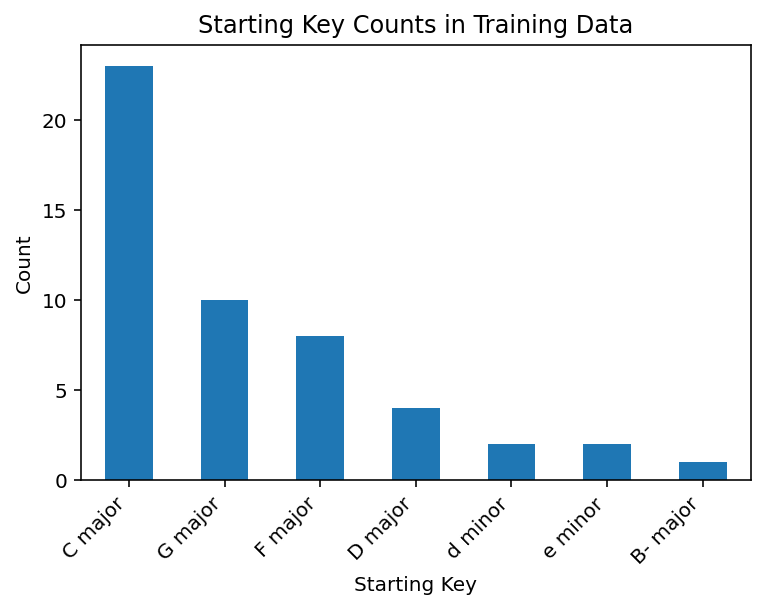

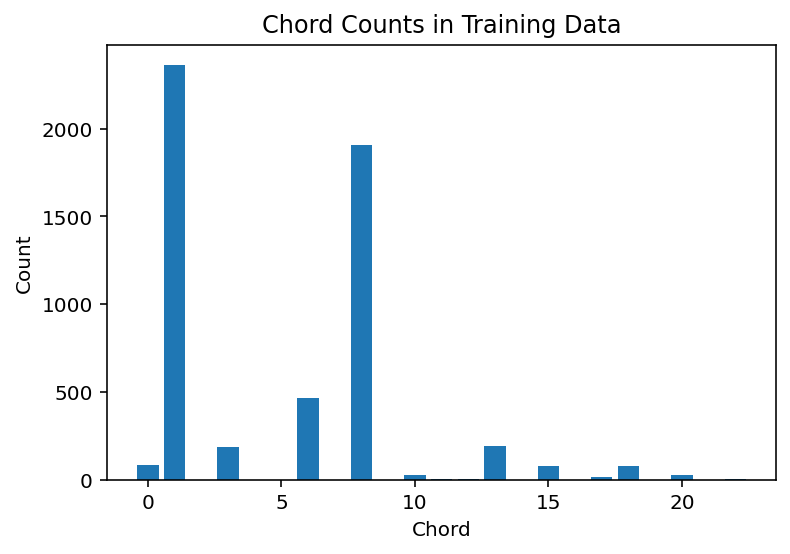

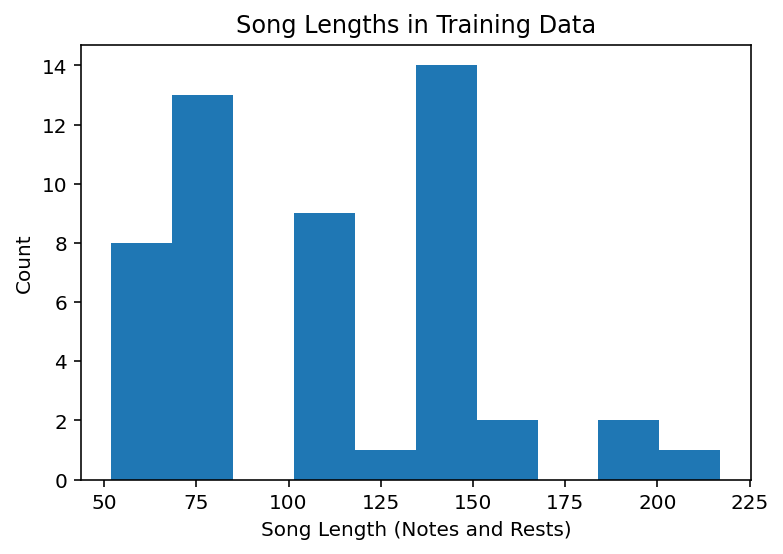

In [7]:
# plot the counts of the MIDI frequencies
# get all of the notes (count the rests and remove them)
all_notes = np.concatenate([np.array(x) for x in vis_df['melody']])
num_rests = np.sum(all_notes == '-')
all_notes = all_notes[all_notes != '-']

# get the high and low values and set the bins
low = np.min(all_notes)
high = np.max(all_notes)
bins = np.linspace(low, high, high - low + 1)

# plot
plt.hist(all_notes, bins=bins)
plt.title("MIDI Note Counts in Training Data")
plt.xlabel("MIDI Frequency")
plt.ylabel("Count")
plt.show()

# print descriptive statistics
print("Number of Rests:", num_rests)
print("Lowest Note MIDI Value:", low)
print("Highest Note MIDI Value:", high)

# create a bar graph of the starting keys
vis_df['keys'].value_counts().plot.bar()
plt.xticks(rotation=45, ha="right")
plt.title("Starting Key Counts in Training Data")
plt.xlabel("Starting Key")
plt.ylabel("Count")
plt.show()

# create a histogram of the chords 
all_chords = np.concatenate([np.array(x) for x in vis_df['chords']])
all_chords = all_chords[all_chords != '-']
chord_list, counts = np.unique(all_chords, return_counts=True)
plt.bar(chord_list, counts)
plt.title("Chord Counts in Training Data")
plt.xlabel("Chord")
plt.ylabel("Count")
plt.show()

# plot the song lengths (number of notes and rests in the song)
vis_df['length'].plot(kind='hist')
plt.title("Song Lengths in Training Data")
plt.xlabel("Song Length (Notes and Rests)")
plt.ylabel("Count")
plt.show()